# Preparations

### Loading Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.exceptions import DataConversionWarning
import warnings
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, Adadelta, Adagrad, RMSprop, Adamax, Nadam
from keras.initializers import glorot_normal
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from tensorflow import logging
import talos as ta
from imblearn.over_sampling import SMOTE
logging.set_verbosity(logging.ERROR)
np.random.seed(123)

Using TensorFlow backend.


### Data Analysis

Our task is to build a predictive model which is able to predict the target variable 'Kauf' based on values of various feature variables. After loading the dataset, we have a look at the data types of each of the 96 variables to get a first overview:

In [0]:
minidata = pd.read_csv("https://raw.githubusercontent.com/gablum/datasets/master/ConversionDataSet.csv")
minidata = minidata.drop('Unnamed: 0', axis=1)
pd.set_option('display.max_rows', 96)
minidata.dtypes

month                               int64
Kauf                                int64
sessionStartHour                    int64
dayOfMonth                          int64
weekday                             int64
sessionTime                         int64
category                           object
pageVisitedBeforeSession            int64
amountBasketSession               float64
totalItemValueBasketSession         int64
sessionProduct                      int64
sessionSearch                       int64
sessionOverview                     int64
sessionSale                         int64
sessionCart                         int64
percPageProduct                   float64
percPageSearch                    float64
percPageOverview                  float64
percPageSale                      float64
percPageCart                      float64
countPagesRevisited                 int64
timeOnPage                          int64
checkoutStep                        int64
clickEventsSession                

The data seems to be diverse regarding the datatypes: It contains mostly continuous variables and also several ordinal and nominal variables. We therefore need to preprocess the data in the Data Preprocessing part (see further below) before starting to train a neural network.

Before that, let´s visualize some of the features with regards to the target variable 'Kauf'. Let's start with weekday. We make two plots to see the difference between weekdays in all the sessions and weekdays in only the sessions where users purchase an item.


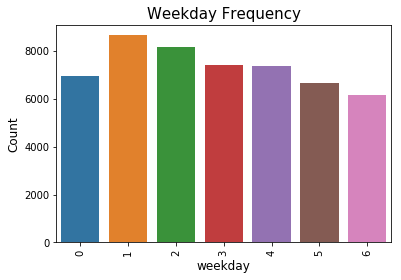

In [0]:
plt.figure(figsize=(6,4))
sns.countplot(x="weekday", data=minidata)
plt.ylabel('Count', fontsize=12)
plt.xlabel('weekday', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Weekday Frequency", fontsize=15)
plt.show()

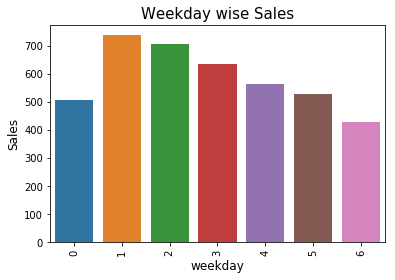

In [0]:
plt.figure(figsize=(6,4))
sns.countplot(x = minidata["weekday"][minidata["Kauf"]==1])
plt.ylabel('Sales', fontsize=12)
plt.xlabel('weekday', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Weekday wise Sales", fontsize=15)
plt.show()

From the two plots we made it is obviously that on day 1, 2 and 3 there are more sales than on the other days. Day 3 and day 4 actually have roughly the same observations, but day 3 has more sales than day 4. Since there is no indication on whether day 1 is Monday, we never know which day is represent exactly by the numbers 0 to 6, but we could assume that 1, 2 and 3 are Friday, Saturday and Sunday respectively, as people like to go shopping online on weekends according to our common sense.


Next, we show the time when people like to go online shopping.

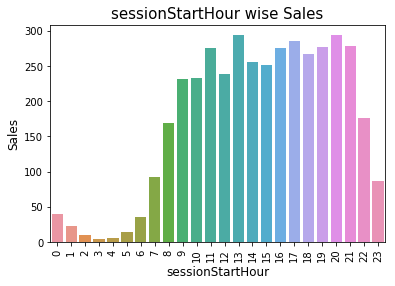

In [0]:
plt.figure(figsize=(6,4))
sns.countplot(x = minidata["sessionStartHour"][minidata["Kauf"]==1])
plt.ylabel('Sales', fontsize=12)
plt.xlabel('sessionStartHour', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("sessionStartHour wise Sales", fontsize=15)
plt.show()

The sales numbers are actully the same as a normal people's routine online life. A normal day starts at 8; at 11 the sales numbers enter the first peak of the day. At 13, the sales numers are the highest through a normal day, maybe it's because after a whole morning of tiring or broing work, people like to buy something to make them happy again. The numbers remain at a high level until 21, which is the time many people go to sleep. After that and during night, the numbers are significantly lower. So the conclusion might be that people are mostly likely to buy stuff online after work, either at noon or at night.

Furthermore, the combination of date and time may also differ with regards to the online sales numbers. To find out the truth behind these two features, we make a beautiful heatmap:

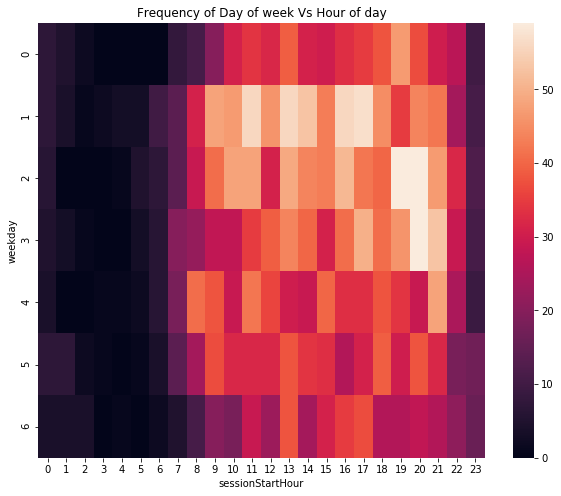

In [0]:
grouped = minidata.groupby(["weekday", "sessionStartHour"])["Kauf"].aggregate("sum").reset_index()
grouped = grouped.pivot('weekday', 'sessionStartHour', 'Kauf')
plt.figure(figsize=(10,8))
sns.heatmap(grouped)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Now we use this fancy heat map to analyze at what day and time people are more likely to make a purchase. The lighter the color, the more sales are recorded. At day 1, 11, 13, 16 and 17 are the most favourable times. At day 2 and day 3, things change, the purchase time shifs more towards night time. Here the most sales are done between 19 and 20.

Since there are so many features in this dataset, it will take too long to analyze everything, but before we jump to next step, we can at least look at three more features:

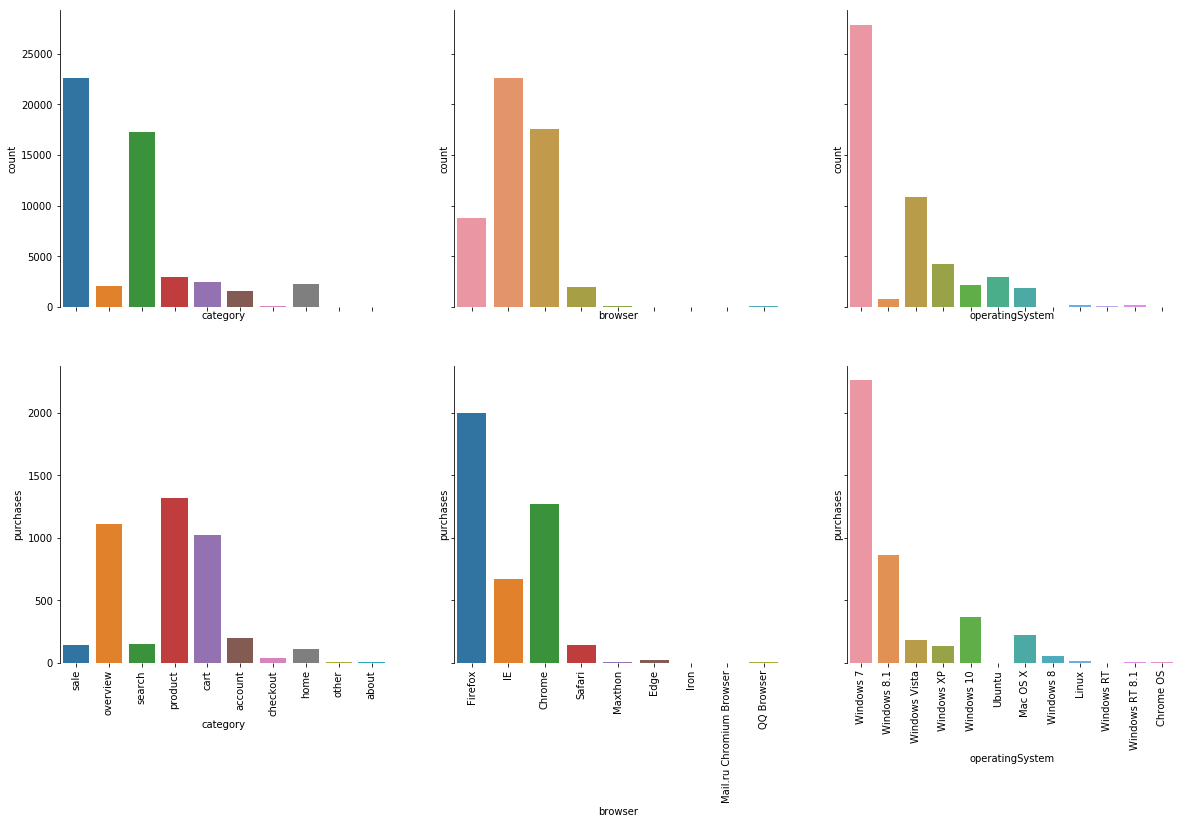

In [0]:
f, ax = plt.subplots(2, 3, figsize=(20, 12),sharex='col', sharey='row')

sns.countplot(x = minidata["category"], ax=ax[0,0])

sns.countplot(x = minidata["browser"], ax=ax[0,1])

sns.countplot(x = minidata["operatingSystem"], ax=ax[0,2])

sns.countplot(x = minidata["category"][minidata["Kauf"]==1], ax=ax[1,0])
ax[1,0].set_xlabel('category')
ax[1,0].tick_params(axis='x',labelrotation = 90)
ax[1,0].set_ylabel("purchases")

sns.countplot(x = minidata["browser"][minidata["Kauf"]==1], ax=ax[1,1])
ax[1,1].set_xlabel('browser')
ax[1,1].tick_params(axis='x',labelrotation = 90)
ax[1,1].set_ylabel("purchases")

sns.countplot(x = minidata["operatingSystem"][minidata["Kauf"]==1], ax=ax[1,2])
ax[1,2].set_xlabel("operatingSystem")
ax[1,2].tick_params(axis='x',labelrotation = 90)
ax[1,2].set_ylabel("purchases")

sns.despine(bottom=True)

The comparision between the total sessions and the sessions in which items are purchased, reveal some interesting facts. Let´s start with with the category of current page. People visit the sales page at most, followed by the search page. However, these two pages are not successful in converting visits to pruchases; the most purchases are done in the product page, following by the overview page and the cart page, these three types are far ahead from the other types, which makes sense, according to their names. A very different behavior regarding viewing and purchasing can be noticed.

Users who use different browsers also show inconsistencies in purchase conversion. People who use IE are less likely to make a purchase, even though IE is the most used browser. On the contrary, Firefox only has the third biggest user group, the purchase they make are yet the highest.

For the operationg systems, Windows 7 is still most people's favourite, it also leads to the biggest sales number. More interestingly, Windows 8.1, although not not being used by many users, has the second place sales wise. Windows 10 users are also showing the same trend as windows 8.1 users, placing third in sales numbers.

### Data Preprocessing

In the first step of preprocessing the data, we one-hot-encode the three categorical variables containing strings (i.e. 'category', 'browser', and 'operatingSystem'). To avoid the "dummy trap", we also need to delete one of the one-hot-encoded variables for each original variable. The original variables can then be deleted as well.

In [0]:
one_hot = pd.get_dummies(minidata['category'])
minidata = minidata.join(one_hot)
one_hot = pd.get_dummies(minidata['browser'])
minidata = minidata.join(one_hot)
one_hot = pd.get_dummies(minidata['operatingSystem'])
minidata = minidata.join(one_hot)
minidata = minidata.drop('overview',axis = 1)
minidata = minidata.drop('IE',axis = 1)
minidata = minidata.drop('Windows 7',axis = 1)
minidata = minidata.drop('category',axis = 1)
minidata = minidata.drop('browser',axis = 1)
minidata = minidata.drop('operatingSystem',axis = 1)

Before specifying our neural network, we need to specify our feature variables and target variable and create a training and test dataset out of the entire dataset:

In [0]:
featurenames = minidata.columns
featurenames = featurenames.delete(1)
X = minidata[featurenames]
y = minidata.Kauf
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

As neural networks work better with standardized variables in general, we now need to standardize all of our variables. Technically, the standardization of the dummy variables should not change its meaning, however, in our case, it turned out that the neural network works better when standardizing them as well. The target variable which we want to predict, however, does not need to be standardized. To not leak the training data to the test set, we only use the training set to build the standardizer.

In [0]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
num_cols = minidata.columns[minidata.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
num_cols = num_cols.delete(1)

scaler = preprocessing.StandardScaler().fit(X_train[num_cols])#mind that we use only X_train values not to leak the data to the test set
X_train= scaler.transform(X_train[num_cols])
X_test= scaler.transform(X_test[num_cols])  